### Phishing Detection URLs
##### Code that extracts features from the dataset of phishing URLs and model trained using Deep Nueral Network 

In [1]:
# Installing Top Level Domain, for getting domains of URLS
!pip install tld

# importing libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tld import get_tld, is_tld
# urlparse for parsing the URL
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 KB 5.2 MB/s eta 0:00:00


In [2]:
# uploading the dataset file
from google.colab import files
file = files.upload()

Saving phishing_site_urls.csv to phishing_site_urls.csv


In [3]:
# reading the data from the csv (dataset) file
df = pd.read_csv('phishing_site_urls.csv')
# Printing data entries to check the data
print('First 20 data entries:')
df.head(20)

First 20 data entries:


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
5,smilesvoegol.servebbs.org/voegol.php,bad
6,premierpaymentprocessing.com/includes/boleto-2...,bad
7,myxxxcollection.com/v1/js/jih321/bpd.com.do/do...,bad
8,super1000.info/docs,bad
9,horizonsgallery.com/js/bin/ssl1/_id/www.paypal...,bad


In [4]:
# Dataframe information
print('Dataframe Information:\n')
df.info()

Dataframe Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


Bar graph for number of good and bad urls:



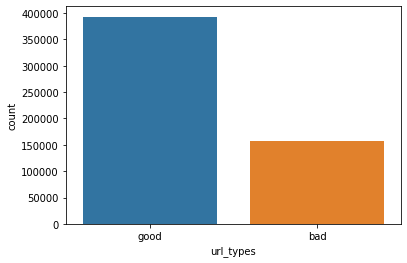

In [5]:
# Plotting bar graph for better understanding of data set, that is number of good and bad urls.
print('Bar graph for number of good and bad urls:\n')
count = df.Label.value_counts()
sns.barplot(x=count.index, y=count)
plt.xlabel('url_types')
plt.ylabel('count');

In [6]:
# creating a copy of dataframe because we don't want to make changes in original dataframe
data = df.copy()

In [7]:
# Extracting features

# Removing duplicates 
duplicates = data.URL.duplicated().sum()
print('\nNumber of duplicates URL: ', duplicates)
if duplicates>0:
  data.drop(data[data.URL.duplicated() == True].index, inplace = True)
  data.reset_index(drop = True)

# Removing 'www.' from the URLs
data['URL'] = data['URL'].replace('www.', '', regex = True)

# Giving number to bad and good label tag
rem = {'Category': {'bad': 0, 'good': 1}}
data['Category'] = data['Label']
data = data.replace(rem)

# Length of URL
data['URL_len'] = data['URL'].apply(lambda x: len(str(x)))

# Getting domain of the URL
def process_tld(url):
  try:
    res = get_tld(url, as_object = True, fail_silently=False, fix_protocol=True)
    pri_domain = res.parsed_url.netloc
  except:
    pri_domain = None
  return pri_domain
data['domain'] = data['URL'].apply(lambda d: process_tld(d))

# Calculating number of different symbols in the URL
features = ['@', '?', '-', '=', ',', '.', '#', '%', '+', '$', '!', '*', '//']
for feature in features:
  data[feature] = data['URL'].apply(lambda f: f.count(feature))

# Getting the hostname for the URL
def abnormal_url(url):
  hostname = urlparse(url).hostname
  hostname = str(hostname)
  match = re.search(hostname, url)
  if match:
    return 1
  else:
    return 0
data['abnormal_url'] = data['URL'].apply(lambda i: abnormal_url(i))

# Checking for HTTP in the URL
def httpSecure(url):
  htp = urlparse(url).scheme
  match = str(htp)
  if match == 'https':
    return 1
  else:
    return 0
data['https'] = data['URL'].apply(lambda i: httpSecure(i))

# Counting number of digits in the URL
def digit_count(url):
  digits = 0
  for i in url:
    if i.isnumeric():
      digits = digits + 1
  return digits
data['digits'] = data['URL'].apply(lambda i: digit_count(i))

# Looking for Shortening Service in the URL
def shortening_service(url):
  match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
  if match:
    return 1
  else:
    return 0
data['shortening_service'] = data['URL'].apply(lambda i: shortening_service(i))

# Looking for IP address
def having_ip_address(url):
  match = re.search('(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' 
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)
  if match:
    return 1
  else:
    return 0
data['having_ip_address'] = data['URL'].apply(lambda i: having_ip_address(i))


Number of duplicates URL:  42151


Bar graph for number of Abnormal URL:



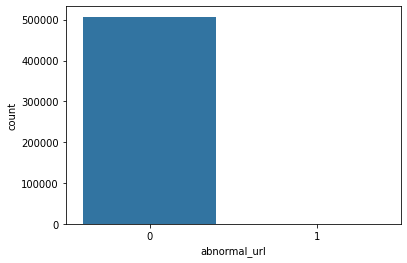

In [8]:
print('Bar graph for number of Abnormal URL:\n')
sns.countplot(x='abnormal_url', data=data);

Bar graph for number of URL having HTTP:



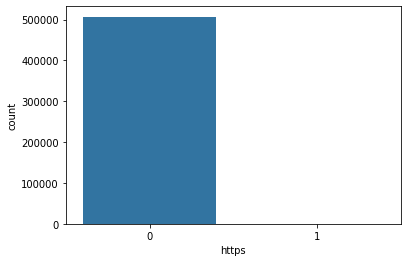

In [9]:
print('Bar graph for number of URL having HTTP:\n')
sns.countplot(x='https', data=data);

Bar graph for number of URL having Shortening Service:



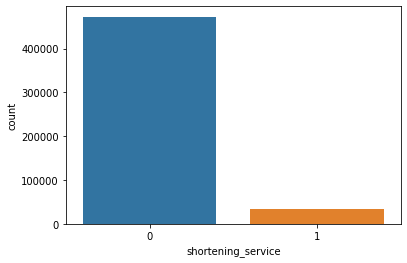

In [10]:
print('Bar graph for number of URL having Shortening Service:\n')
sns.countplot(x='shortening_service', data=data);

In [11]:
print('Number of URL having and not having IP address:')
data['having_ip_address'].value_counts()

Number of URL having and not having IP address:


0    503166
1      4029
Name: having_ip_address, dtype: int64

In [12]:
# Dataframe after feature extraction
print('Dataframe after feature extraction(Random Data entries):\n')
data.sample(20)

Dataframe after feature extraction(Random Data entries):



,URL,Label,Category,URL_len,domain,@,?,-,=,",",...,+,$,!,*,//,abnormal_url,https,digits,shortening_service,having_ip_address
48844,agrifeeds.org/en/node/1044/xml,good,1,30,agrifeeds.org,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0
104841,triathlon.is/wp-admin/includes/ozor/index.php?...,bad,0,76,triathlon.is,0,1,1,0,0,...,0,0,0,0,0,0,0,10,0,0
46291,tablet3g.com.br/wp-content/uploads/2012/03/bt....,bad,0,133,tablet3g.com.br,0,0,1,1,0,...,0,0,0,0,0,0,0,7,1,0
368714,kirkegaard.com/arts/recital-halls,good,1,33,kirkegaard.com,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
510829,rabavolgy.hu/utmu1mc,bad,0,20,rabavolgy.hu,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
117627,magneticnaildesign.ca/magneticnaildesign2/modu...,bad,0,55,magneticnaildesign.ca,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
467481,xbiz.com/news/121480,good,1,20,xbiz.com,0,0,0,0,0,...,0,0,0,0,0,0,0,6,0,0
419415,radio-locator.com/cgi-bin/finder?sr=Y&call=KUDL,good,1,47,radio-locator.com,0,1,2,2,0,...,0,0,0,0,0,0,0,0,0,0
224972,pages.ebay.com/help/policies/accepted-payments...,good,1,58,pages.ebay.com,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
391027,monorailtrespassing.com/livetwo.html,good,1,36,monorailtrespassing.com,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Creating X and Y dataset, to split data and train the data
X = data.drop(['URL', 'Label', 'Category', 'domain'], axis=1)
Y = data['Category']

# Splitting data in training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Training our model (Deep neural network)
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dnn = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Testing our model and comparing true values and predicted values of Y
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy: {:.2f}%\n".format(accuracy * 100))

# Confusion matrix for checking how many values are predicted right and wrong
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n{}'.format(cm))

Epoch 1/10
12680/12680 [==============================] - 35s 3ms/step - loss: 0.4051 - accuracy: 0.8382 - val_loss: 0.3761 - val_accuracy: 0.8449
Epoch 2/10
12680/12680 [==============================] - 33s 3ms/step - loss: 0.3790 - accuracy: 0.8434 - val_loss: 0.3649 - val_accuracy: 0.8467
Epoch 3/10
12680/12680 [==============================] - 38s 3ms/step - loss: 0.3724 - accuracy: 0.8465 - val_loss: 0.3609 - val_accuracy: 0.8504
Epoch 4/10
12680/12680 [==============================] - 33s 3ms/step - loss: 0.3694 - accuracy: 0.8479 - val_loss: 0.3594 - val_accuracy: 0.8500
Epoch 5/10
12680/12680 [==============================] - 33s 3ms/step - loss: 0.3675 - accuracy: 0.8489 - val_loss: 0.3578 - val_accuracy: 0.8520
Epoch 6/10
12680/12680 [==============================] - 34s 3ms/step - loss: 0.3662 - accuracy: 0.8498 - val_loss: 0.3563 - val_accuracy: 0.8525
Epoch 7/10
12680/12680 [==============================] - 34s 3ms/step - loss: 0.3652 - accuracy: 0.8500 - val_loss: 0

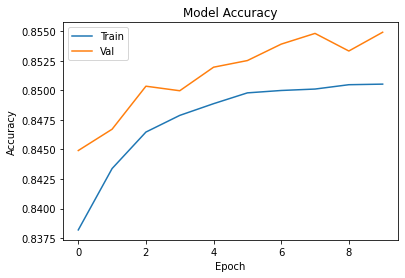

In [25]:
# Plotting graph to show accuracy
plt.plot(dnn.history['accuracy'])
plt.plot(dnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()